In [133]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None


In [134]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

for file_path in list((notebooks_path / data_path).glob("*.parquet")):
    # retrieve the name of the file without the extension for all OS
    df = pd.read_parquet(file_path)
    # if "Time" in df.columns:
    #     df["Time"] = pd.to_datetime(df["Time"])
    data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0]] = df


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height", "ICUType"]
# dynamic variables
dynamic_vars = data_dir["set-a"].columns.difference(stationary_vars + ID_vars).tolist()
# # key_translator for data dict
# translate_key_inv = {"set-a": "train", "set-b": "valid", "set-c": "test", 
#                  "Outcomes-a": "train_label", "Outcomes-b": "valid_label", "Outcomes-c": "test_label"}
# # invert translate_key
# translate_key = {v: k for k, v in translate_key_inv.items()}



## Simple EDA

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          200 non-null    int32   
 1   Gender       200 non-null    category
 2   ICUType      200 non-null    category
 3   Weight       200 non-null    float64 
 4   HeartRate    200 non-null    float64 
 5   AgeGroup     200 non-null    category
 6   WeightGroup  200 non-null    category
dtypes: category(4), float64(2), int32(1)
memory usage: 5.4 KB


In [136]:
data.describe()

,Age,Weight,HeartRate
count,200.000000,200.000000,200.000000
mean,53.320000,69.915325,80.241874
std,20.843219,10.421836,12.084164
min,18.000000,42.192623,40.790929
25%,37.000000,63.185015,72.126466
50%,54.000000,70.449658,80.751366
75%,71.000000,76.868283,88.886567
max,89.000000,99.706999,107.047928


In [137]:
# search for cathegorial like variables
threshold = 20
for col in data.columns:
    if len(data[col].unique()) < threshold:
        print(f"{col}: {data[col].unique()}")  # unique values for each column

Gender: ['Female', 'Male']
Categories (2, object): ['Female', 'Male']
ICUType: ['Surgical', 'Medical', 'Cardiac']
Categories (3, object): ['Cardiac', 'Medical', 'Surgical']
AgeGroup: ['51-70', '71+', '18-30', '31-50']
Categories (4, object): ['18-30' < '31-50' < '51-70' < '71+']
WeightGroup: ['60-80kg', '>80kg', '<60kg']
Categories (3, object): ['<60kg' < '60-80kg' < '>80kg']


In [138]:
# some basic data engineering

# new column AgeGroup with binning of 5 years
data['AgeGroup'] = pd.cut(data['Age'], bins=[17, 30, 50, 70, 100], labels=['18-30', '31-50', '51-70', '71+'])

# new column Weight Group with binning of 10 kg
data['WeightGroup'] = pd.cut(data['Weight'], bins=[0, 60, 80, 100], labels=['<60kg', '60-80kg', '>80kg'])

# cathegorize vars
categorical_cols = ['Gender', 'ICUType', 'AgeGroup', 'WeightGroup']
data[categorical_cols] = data[categorical_cols].astype('category')


### NA Patterns

In [139]:
data = data_dir["set-a"].copy()

print("Shape of train data: ", data.shape)
print("NA counts: ")
data.isna().sum().sort_values(ascending=False).head(10)
# train.head()

Shape of train data:  (196000, 44)
NA counts: 


Parameter
TroponinI      195754
Cholesterol    195658
TroponinT      194909
Albumin        194651
AST            194424
ALP            194376
ALT            194376
Bilirubin      194253
SaO2           192539
RespRate       192095
dtype: int64

<Axes: xlabel='Parameter'>

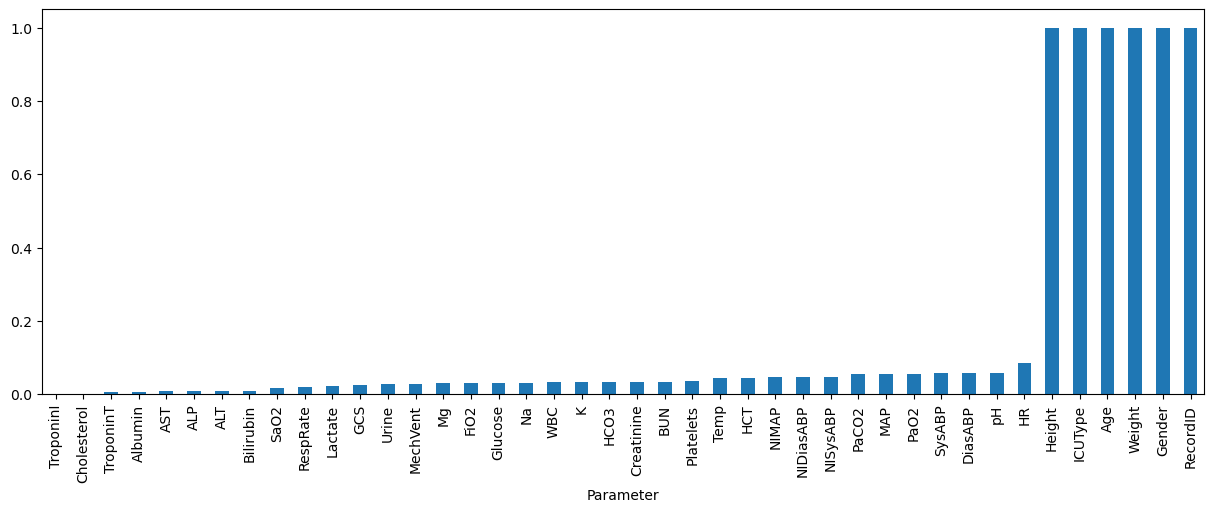

In [140]:
# number available measurements per variable per patient
na_groups = ["PatientID", "Time"]
data.groupby(na_groups[:]).count().mean().sort_values()
data.groupby(na_groups[:]).count().mean().sort_values().plot(kind="bar", figsize=(15, 5))
# print(dynamic_vars)

Number of patients with more than 1 observation in more than 5 variables: 535
Number of variables with more than 1 observation in more than 100 patients: 28


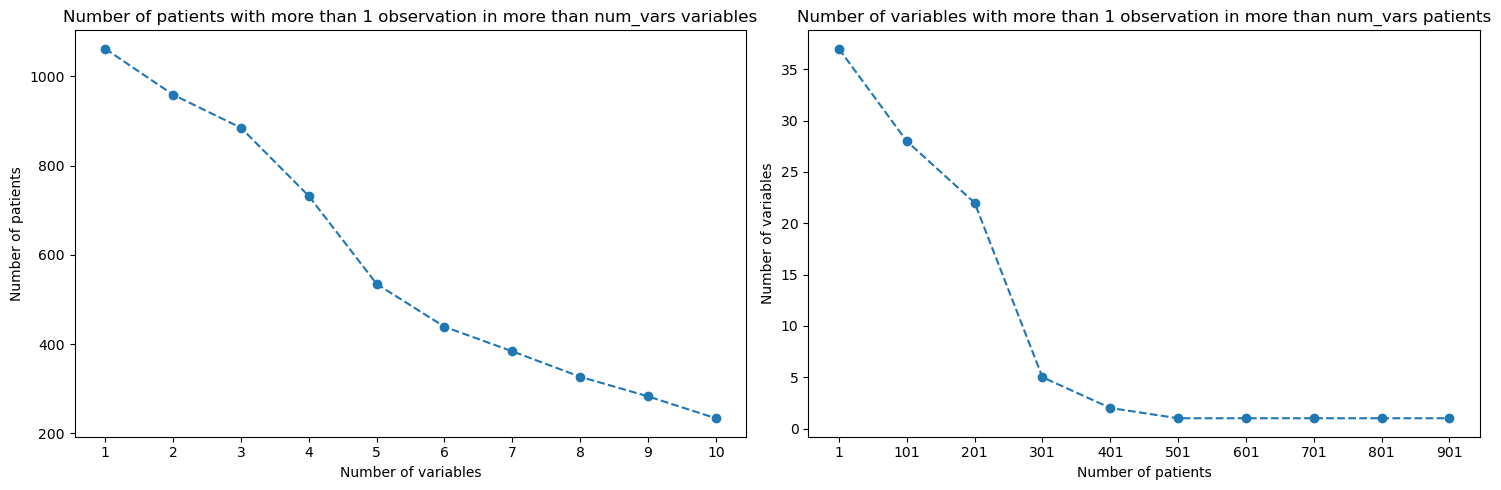

In [141]:

patients_var_counts = data.groupby("PatientID").count()[dynamic_vars]

# list patients that have more than 1 observation in more than num_vars variables
num_vars_patients = 5
num_vars_columns = 100

patient_count_greater_numvars = patients_var_counts[(patients_var_counts > 1).sum(axis=1) > num_vars_patients].index.tolist()
# variable_count_greater_numvars = patients_var_counts[((patients_var_counts > 1).sum(axis=0) > num_vars_columns).index.tolist()]
variable_count_greater_numvars = patients_var_counts.columns[((patients_var_counts > 1).sum(axis=0) > num_vars_columns)]
print("Number of patients with more than 1 observation in more than {} variables: {}".format(num_vars_patients, len(patient_count_greater_numvars)))
print("Number of variables with more than 1 observation in more than {} patients: {}".format(num_vars_columns, variable_count_greater_numvars.shape[0]))

loop_num_vars_patients = 10
loop_num_vars_columns = 1000
# plot the data by looping over num_vars_patients
patient_count_greater_numvars_list = [patients_var_counts[(patients_var_counts > 1).sum(axis=1) > num_vars_patients].index.tolist() for num_vars_patients in np.arange(1, loop_num_vars_patients+1)]
variable_count_greater_numvars_list = [patients_var_counts.columns[((patients_var_counts > 1).sum(axis=0) > num_vars_columns)].tolist() for num_vars_columns in np.arange(1, loop_num_vars_columns+1, 100)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.arange(1, loop_num_vars_patients+1), [len(x) for x in patient_count_greater_numvars_list], "o--")
ax[0].set_xlabel("Number of variables")
ax[0].set_ylabel("Number of patients")
ax[0].set_title("Number of patients with more than 1 observation in more than num_vars variables")
ax[0].set_xticks(np.arange(1, loop_num_vars_patients+1))
ax[1].plot(np.arange(1, loop_num_vars_columns+1, 100), [len(x) for x in variable_count_greater_numvars_list], "o--")
ax[1].set_xlabel("Number of patients")
ax[1].set_ylabel("Number of variables")
ax[1].set_title("Number of variables with more than 1 observation in more than num_vars patients")
ax[1].set_xticks(np.arange(1, loop_num_vars_columns+1, 100))
plt.tight_layout()
plt.show()

### Univariate analysis

In [ ]:
# Dropdowns
column_selector = widgets.Dropdown(
    options=data.columns.tolist(),
    description='Feature:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

groupby_selector = widgets.Dropdown(
    options=['None', 'AgeGroup', 'Gender', 'ICUType', 'WeightGroup'],
    value='None',
    description='Color by:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def display_histogram(column, groupby):
    output.clear_output(wait=True)
    with output:
        col_data = data[column].dropna()
        plt.figure(figsize=(8, 5))
        
        if np.issubdtype(col_data.dtype, np.number):
            # Summary stats
            stats = {
                'Mean': np.mean(col_data),
                'Median': np.median(col_data),
                'Std': np.std(col_data),
                'Min': np.min(col_data),
                'Max': np.max(col_data),
                'IQR': np.percentile(col_data, 75) - np.percentile(col_data, 25)
            }
            title = ', '.join([f'{k}: {v:.2f}' for k, v in stats.items()])
            
            if groupby != 'None' and groupby in data.columns:
                for group_val in data[groupby].dropna().unique():
                    subset = data[data[groupby] == group_val][column].dropna()
                    plt.hist(subset, bins=20, alpha=0.5, label=str(group_val), edgecolor='black')
                plt.legend()
            else:
                plt.hist(col_data, bins=20, color='skyblue', edgecolor='black', alpha=0.75)

            plt.title(f'{column} Histogram\n{title}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        
        else:
            # For categorical: bar plot
            if groupby != 'None' and groupby in data.columns:
                cross_tab = pd.crosstab(data[column], data[groupby])
                cross_tab.plot(kind='bar', stacked=True, edgecolor='black', alpha=0.8, figsize=(8, 5))
                plt.title(f'{column} Count by {groupby}')
                plt.xlabel(column)
                plt.ylabel('Count')
                plt.tight_layout()
                plt.show()
                return
            else:
                value_counts = col_data.value_counts()
                value_counts.plot(kind='bar', color='lightcoral', edgecolor='black', alpha=0.8)
                plt.title(f'{column} Value Counts\nMode: {col_data.mode()[0]}, Unique: {col_data.nunique()}')
                plt.xlabel(column)
                plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

# Link widgets to function
widgets.interact(display_histogram, column=column_selector, groupby=groupby_selector)
display(output)


interactive(children=(Dropdown(description='Feature:', layout=Layout(width='50%'), options=('Time', 'BUN', 'Cr…

Output()

In [ ]:
## Dynamic Variable Analysis
# TODO add mask to explore patents with actual observations

# Dropdowns
value_selector = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['Time', 'PatientID']],
    description='Y-Axis Variable:',
    layout=widgets.Layout(width='50%')
)

patient_selector = widgets.SelectMultiple(
    options=sorted(data['PatientID'].unique()),
    # value=('P001',),
    description='Patients:',
    layout=widgets.Layout(width='50%', height='120px')
)

output = widgets.Output()

# Plotting function
def plot_time_series(y_col, PatientIDs):
    output.clear_output(wait=True)
    with output:
        plt.figure(figsize=(10, 5))
        for pid in PatientIDs:
            data_pid = data[data['PatientID'] == pid]
            plt.plot(data_pid['Time'], data_pid[y_col], label=f'Patient {pid}')
        plt.title(f'{y_col} over Time')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

# Link interaction
widgets.interact(plot_time_series, y_col=value_selector, PatientIDs=patient_selector)
display(output)


interactive(children=(Dropdown(description='Y-Axis Variable:', layout=Layout(width='50%'), options=('BUN', 'Cr…

Output()